# Chapter 5: Tool Use (Function Calling)
에이전트가 유용하게 작동하고 실제 세계나 외부 시스템과 상호작용 하기 위해서는 툴을 사용할 능력이 필요하다.     

Tool Use Pattern은, Function Calling 메커니즘으로 동작하는, 에이전트가 외부 API, 데이터베이스, 서비스, 실행 코드와 상호작용 할 수 있게한다. LLM이 사용자의 요청 혹은 태스크의 현재 상태에 기반해서 특정 외부 함수를 언제, 어떻게 사용할지 결정할수 있게한다.    

프로세스는 
1. Tool Definition : 외부 함수나 기능이 LLM에 정의된다. 함수의 목적, 이름, 파라미터
2. LLM Decision : 사용자의 요청과 사용가능한 툴 정의를 받아, 이해를 하고, 하나 이상의 도구 호출이 필요한지 판단
3. Function Call Generation : 툴을 사용하기로 결정하면, 호출할 도구 이름과 파라미터를 structured output 로 생성
4. Tool Execution : 에이전트 프레임워크 또는 오케스트레이션 레이어에서 구조화된 응답을 받아 툴을 실행
5. Observation/Result : 툴 실행의 결과가 에이전트로 돌아온다
6. LLM Processing ( Optional but common ) : 툴의 결과를 컨텍스트로 받고 사용자에게 전달할 최종 응답을 생성하고나 워크플로우(다른 툴 호출, reflection 등등)에서 다음 스텝 결정에 사용

이 패턴은 중요한데, LLM의 학습 데이터 한계를 극복, 최신 정보 접근, 계산 수행, 사용자 맞춤 데이터와 상호작용, 현실 세계 액션 트리거를 가능하게 해주기 때문이다. 

`function calling`에서 더 넓은 범주인 `tool calling`은 에이전트의 능력이 단순히 함수 실행을 넘어 훨씬 더 정교한 시스템을 상상할 수 있게한다. `tool calling`라는 표현이 에이전트가 다양한 리소스와 객체로 구성된 에코시스템 속에서 오케스트레이터로 작동할 수 있는 잠재력을 포착하는 표현

## Practical Application & Use Cases
액션을 수행하거나 특정한, 동적인 정보를 가져와야하는 모든 상황에서 적용될 수 있다.

1. Information Retrievala from External Sources : LLM의 학습 데이터에 없는 정보나 실시간 데이터 접근
- Use Case : 날씨 에이전트
    - Tool : 날씨 API로 위치를 받아 현재 날씨 상태를 반환
    - Agent Flow : 런던 날씨는?(U) -> 날씨 툴 호출 필요 식별(LLM) -> 런던 날씨 툴 호출(LLM) -> 응답 반환 -> 응답 생성(LLM)
2. Interacting with Databases and APIs : 쿼리, 업데이트 혹은 다른 연산
- Use Case : 이커머스 에이전트
    - Tools : 제품 재고 확인 API, 주문 상태 API, 결제 프로세스 API
    - Agent Flow : 제품 X 있음? -> 재고 API 호출(LLM) -> 응답 반환 -> 응답 생성(LLM)
3. Performing Calculations and Data Analysis : 외부 계산기, 데이터 분석 패키지, 통계 툴 사용
- Use Case : 재무 에이전트
    - Tools : 계산 함수, 주식 마켓 데이터 API, 스프레드시트 툴
    - Agent Flow : AAPL의 현재 가격과 150$에서 100주 구매시 잠재 이익? -> 주식 API 호출(LLM) -> 응답 반환 -> 계산 툴 호출 -> 응답 반환 -> 응답 생성(LLM)
4. Sending Communications : 이메일, 문자, API 호출
- Use Case : 개인 비서 에이전트
    - Tool : 이메일 API
    - Agent Flow : "존에게 내일 미팅에 대해 이메일 보내" -> 이메일 툴 호출(LLM)
5. Executing Code : 특정 태스크 수행을 위해 안전한 환경에서 코드 스니펫 실행
- Use Case : 코딩 어시스턴트 에이전트
    - Tool : 코드 인터프리터
    - Agent Flow : 코드 스니펫으로 "이 코드가 하는 일은?" -> 인터프리터 툴 사용(LLM) -> 결과 분석(LLM)
6. Controlling Other Systems or Devices : 스마트 홈 디바이스, IOT 플랫폼, 다른 연결된 시스템과 상호작용
- Use Case : 스마트 홈 에이전트
    - Tool : 스마트 조명 제어 API
    - Agent Flow : "조명 꺼줘" -> 스마트 홈 툴 호출(LLM)
     
Tool Use는 언어 모델을 텍스트 생성기에서 디지털 혹은 물리적 세계에서 센싱, 추론, 액션할수 있는 에이전트로 바꿔준다.

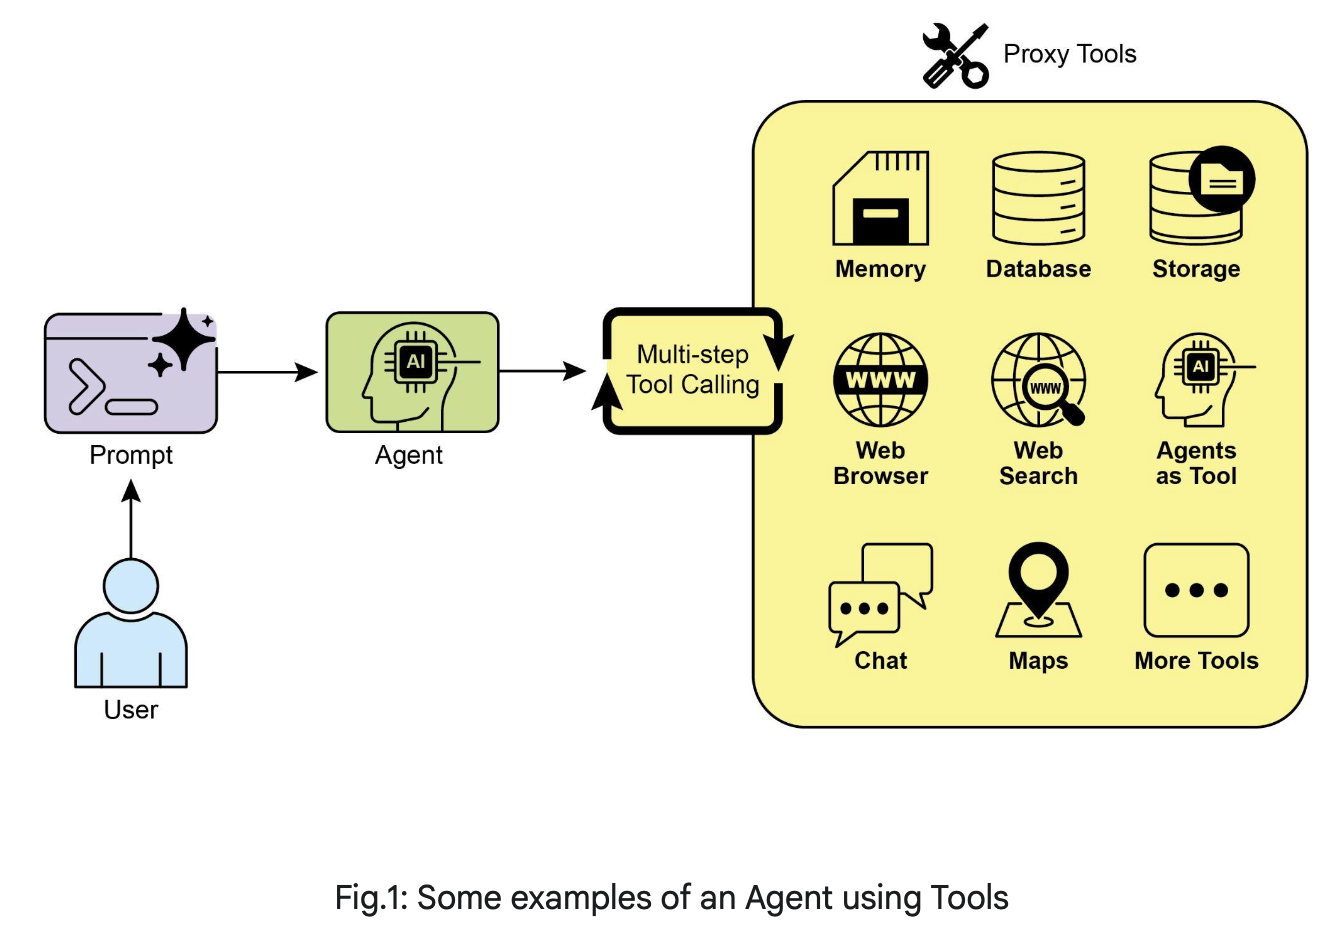


In [1]:
from langchain.tools import tool

from llm import LocalLLM

@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm = LocalLLM()
llm_with_tools = llm.bind_tools(tools)

In [2]:
from typing_extensions import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage
from IPython.display import Image, display

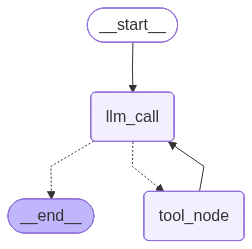

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (sOMbngM6qR1hGG4hVTfBea7gCz5BrCWB)
 Call ID: sOMbngM6qR1hGG4hVTfBea7gCz5BrCWB
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [4]:
# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

In [ ]:
from langgraph.prebuilt import ToolNode